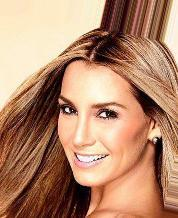

In [2]:
from IPython.display import Image, display
display(Image("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg"))

In [3]:
#necessary libraries
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
#parameters
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
SAVE_FREQ = 10

In [5]:
class CBADataset(Dataset):
    def __init__(self, img_dir, attr_file, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.attr = pd.read_csv(attr_file)
        self.transform = transform
    def __len__(self):
        return len(self.attr)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, "{:06d}.jpg".format(idx+1))
        image = read_image(img_path)
#         label = self.attr.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image

mean = [0.485, 0.456, 0.406] ### this values of mean and std are derived from the ImageNet 
std = [0.229, 0.224, 0.225] ### which works well for many computer vision tasks

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=False),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
    
img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
attr_file = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
dataset = CBADataset(img_dir, attr_file, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
next(iter(dataloader)).size()

torch.Size([256, 3, 64, 64])

In [6]:
#define the Critic
class Critic(nn.Module):
    def __init__(self, image_size, channels):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1), #64x32x32
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), #128x16x16
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), #256x8x8
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), #512x4x4
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1, kernel_size=4, stride=1), #1x1x1
            nn.LeakyReLU(0.2),
            nn.Flatten() # 1x1 1row x 1col
         )
    
    def forward(self, x):
        x = self.conv_layers(x)
        return x
critic = Critic(IMAGE_SIZE, CHANNELS)
critic(torch.randn(BATCH_SIZE, 3,64,64)).size()

torch.Size([256, 1])

In [7]:
#genrator
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super().__init__()
        self.z_dim = z_dim   #128 here
        self.channels = channels  #out channels (3 here)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False), #512x4x4
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), #256x8x8
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), #128x16x16
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), #64x32x32
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, self.z_dim, 1, 1) #256 128x1x1
        x = self.main(x) #256 3x64x64
        return x

generator = Generator(Z_DIM, CHANNELS)
generator(torch.randn(BATCH_SIZE, Z_DIM)).size()

torch.Size([256, 3, 64, 64])

In [13]:
class WGANGP(nn.Module):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight
        
#         self.c_wass_loss_metric = torch.nn.MSELoss(reduction='mean')
#         self.c_gp_metric = torch.nn.MSELoss(reduction='mean')
#         self.c_loss_metric = torch.nn.MSELoss(reduction='mean')
#         self.g_loss_metric = torch.nn.MSELoss(reduction='mean')

        
    def compile(self, g_optimizer, c_optimizer, device):
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        
        # Move optimizer's state to the same device as the model
        for optimizer in [self.c_optimizer, self.g_optimizer]:
            for state in optimizer.state.values():
                for key, value in state.items():
                    if isinstance(value, torch.Tensor):
                        state[key] = value.to(device)
        
        
    def gradient_penalty(self, real_images, fake_images):
        alpha = torch.rand(real_images.size(0), 1, 1, 1, device = real_images.device) #256 1x1x1
        interpolated = (alpha*real_images + (1-alpha)*fake_images).requires_grad_(True)
        pred = self.critic(interpolated)
        
        #calculating gradients of pred wrt interpolated
        gradients = torch.autograd.grad(outputs=pred, inputs=interpolated,
                                  grad_outputs=torch.ones_like(pred),
                                  create_graph=True, retain_graph=True)[0] #256 3x64x64
        
        gradients = gradients.view(gradients.size(0), -1) #256x12288
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() #dim=1 row wise
        return gradient_penalty  #per batch

    
    def train_step(self, real_images):
        batch_size = real_images.size(0)
        
        #update critic
        for i in range(self.critic_steps):
            self.c_optimizer.zero_grad()
            
            random_latent_vectors = torch.randn(batch_size, self.latent_dim, device = real_images.device)
            fake_images = self.generator(random_latent_vectors)
            fake_predictions = self.critic(fake_images)
            real_predictions = self.critic(real_images)
            
            c_wass_loss = torch.mean(fake_predictions) - torch.mean(real_predictions)
            c_gp = self.gradient_penalty(real_images, fake_images)
            c_loss = c_wass_loss + c_gp*self.gp_weight
            
            c_loss.backward()
            self.c_optimizer.step()
        
        
        #update generator
        self.g_optimizer.zero_grad()
        
        random_latent_vectors = torch.randn(batch_size, self.latent_dim, device = real_images.device)
        fake_images = generator(random_latent_vectors)
        fake_predictions = self.critic(fake_images)
        g_loss = -torch.mean(fake_predictions)  #we want to maximize the generator loss and minimise the discriminator loss
        
        g_loss.backward()
        self.g_optimizer.step()
        
#         print(c_gp)
#         self.c_loss_metric.update(c_loss)
#         self.c_wass_loss_metric.update(c_wass_loss)
#         self.c_gp_metric.update(c_gp)
#         self.g_loss_metric.update(g_loss)
        
        return c_loss.item(), c_wass_loss.item(), c_gp, g_loss.item()
# generator = Generator(Z_DIM, CHANNELS)
# real_images = torch.randn(BATCH_SIZE, 3, 64, 64)
# fake_images = generator(torch.randn(BATCH_SIZE, Z_DIM))
# wgangp = WGANGP(
#     critic=critic,
#     generator=generator,
#     latent_dim=Z_DIM,
#     critic_steps=CRITIC_STEPS,
#     gp_weight=GP_WEIGHT,
# )
# # wgangp.train_step(real_images)

In [14]:
critic = Critic(IMAGE_SIZE, CHANNELS)
generator = Generator(Z_DIM, CHANNELS)
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)
# wgangp.train_step(real_images)

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

if LOAD_MODEL:
    # Load weights if specified
    wgangp.load_state_dict(torch.load("./checkpoint/checkpoint.pth"))

if device != torch.device('cpu'):
    wgangp.to(device)
    
wgangp.compile(
    c_optimizer=optim.Adam(
        wgangp.critic.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, ADAM_BETA_2)
    ),
    g_optimizer=optim.Adam(
        wgangp.generator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, ADAM_BETA_2)
    ),
    device=device
)
# wgangp.train_step(real_images)
os.makedirs("./checkpoint", exist_ok=True)
os.makedirs("./output", exist_ok=True)
# os.makedirs("./logs", exist_ok=True)
os.makedirs("./models", exist_ok=True)

In [19]:
#training loop
for epoch in range(1, EPOCHS+1):
    critic_loss = 0
    generator_loss = 0
    
    for batch, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        c_loss, c_wass_loss, c_gp, g_loss = wgangp.train_step(real_images)
        critic_loss += c_loss
        generator_loss += g_loss
        
        print(f"{batch} batch processed")
        
    print(f"Critic Loss:{critic_loss}, Generator Loss:{generator_loss}")
     
    #generate images at each epoch
    with torch.no_grad():
        random_latent_vectors = torch.randn(10, Z_DIM, device=device)
        generated_images = generator(random_latent_vectors)
        save_image(generated_images * 0.5 + 0.5, f'./output/generated_img_{epoch:03d}.png')

    # Save model checkpoints
    if epoch % SAVE_FREQ == 0:
        torch.save(wgangp.state_dict(), f"./checkpoint/checkpoint_{epoch}.pth")
    
    break
# Save the final models
torch.save(generator.state_dict(), "./models/generator.pth")
torch.save(critic.state_dict(), "./models/critic.pth")


0 batch processed
1 batch processed
2 batch processed
3 batch processed
4 batch processed
5 batch processed
6 batch processed
7 batch processed
8 batch processed
9 batch processed
10 batch processed
11 batch processed
12 batch processed


KeyboardInterrupt: 

In [18]:
print(f"{EPOCHS} Epochs completed successfully." )

200 Epochs completed successfully.


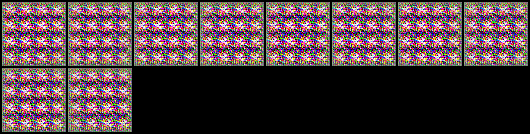

In [78]:
from IPython.display import Image, display
display(Image("/kaggle/working/output/generated_img_000.png"))

In [80]:
print('Hello')

Hello
